In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from PIL import Image

class MyDataset(torch.utils.data.Dataset):
  'Caractérise un jeu de données pour PyTorch'
  def __init__(self, transforms = None, root_dir = 'data', mode = 'train'):
        'Initialisation'
        self.df = pd.read_json(f"{root_dir}/{mode}.jsonl", lines=True)
        self.labels = self.df.label
        self.image_names = self.df.img
        self.transforms = transforms
        self.root_dir = root_dir
#        print(len(self.labels[self.labels == 0])/len(self.labels))
      
  def __len__(self):
        "Représente le nombre total d'exemples du jeu de données"
        return len(self.labels)

  def __getitem__(self, idx):
      'Génère un exemple à partir du jeu de données'
      # Sélection de l'exemple
      if torch.is_tensor(idx):
            idx = idx.tolist()

      image_path = f"{self.root_dir}/{self.image_names.iloc[idx]}"

      img = Image.open(image_path, )

      if self.transforms :
            img = self.transforms(img)

      return img, self.labels.iloc[idx]



In [3]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

alpha_buster = lambda x: x[:3, :, :]

# Loading and normalizing the data.
# Define transformations for the training and test sets
transformations = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    alpha_buster,
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 1
number_of_labels = 1



In [4]:
train_set = MyDataset(transforms=transformations)
test_set = MyDataset(transforms= transformations, mode= 'dev')

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
print("The number of images in a training set is: ", len(train_loader)*batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

The number of images in a training set is:  8500
The number of images in a test set is:  500


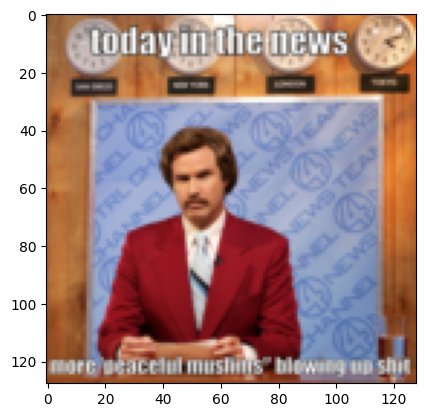

In [5]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    
    
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))

def main():
    # get some random training images
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    # show images
    imshow(images)
  

if __name__ == "__main__":
    main()

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
       self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
       self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
       self.pool = nn.MaxPool2d(2, 2)
       self.fc1 = nn.Linear(16384, 64)
       self.fc2 = nn.Linear(64, 1)
       self.dropout = nn.Dropout(0.1)

   def forward(self, x):
       # add sequence of convolutional and max pooling layers
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = self.pool(F.relu(self.conv3(x)))
       x = x.view(-1, 16384)
       x = self.dropout(x)
       x = F.relu(self.fc1(x))
       x = self.dropout(x)
       x = torch.sigmoid(self.fc2(x))
       
       return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [7]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(80736, 1)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))
        output = output.view(-1,80736)
        output = self.fc1(output)
        output = torch.sigmoid(output)
        return output

# Instantiate a neural network model 
model1 = Network()
print(model1)


Network(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=80736, out_features=1, bias=True)
)


In [8]:
from torch.optim import Adam

 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.BCELoss()
def opti(mod):
    return Adam(mod.parameters(), lr=0.001, weight_decay=0.0001)

In [9]:
from torch.autograd import Variable

# Function to save the model
def saveModel(mod):
    path = "./myFirstModel.pth"
    torch.save(mod.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(mod):
    
    mod.eval()
    accuracy = 0.0
    total = 0.0
    i = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = mod(images)
            
            predicted = (outputs.data >= 0.5).int()
            
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            i +=1 
            if i % 50 == 49:
                print(outputs)
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs, mod):
    best_accuracy = 0.0
    optimizer = opti(mod)
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    mod.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = mod(images)
            # compute the loss based on model output and real labels
            
            loss = loss_fn(outputs, labels.float().reshape(-1,1))
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000  
                print(f'[{epoch +1}, {i + 1}] loss: {running_loss / 1000 :.3f}')
                # zero the loss
                running_loss = 0.0

        
        # we want to save the model if the accuracy is the best
        accuracy = testAccuracy(mod)
        if accuracy > best_accuracy:
            saveModel(mod)
            best_accuracy = accuracy

        
        print(f'For epoch {epoch +1} the test accuracy over the whole test set is {accuracy} %')

In [11]:
print(testAccuracy(model1))
print(testAccuracy(model))

tensor([[0.4997]])
tensor([[0.4982]])
tensor([[0.4980]])
tensor([[0.4988]])
tensor([[0.4975]])
tensor([[0.4983]])
tensor([[0.4986]])
tensor([[0.4991]])
tensor([[0.4986]])
tensor([[0.4990]])
50.2
tensor([[0.4690]])
tensor([[0.4694]])
tensor([[0.4697]])
tensor([[0.4689]])
tensor([[0.4686]])
tensor([[0.4684]])
tensor([[0.4716]])
tensor([[0.4685]])
tensor([[0.4713]])
tensor([[0.4685]])
50.0


In [12]:
train(2, model1)

The model will be running on cpu device
[1, 1000] loss: 0.685
[1, 2000] loss: 0.670
[1, 3000] loss: 0.656
[1, 4000] loss: 0.652
[1, 5000] loss: 0.657
[1, 6000] loss: 0.651
[1, 7000] loss: 0.635
[1, 8000] loss: 0.663
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
tensor([[0.3593]])
For epoch 1 the test accuracy over the whole test set is 50.0 %
[2, 1000] loss: 0.652
[2, 2000] loss: 0.636
[2, 3000] loss: 0.662
[2, 4000] loss: 0.649
[2, 5000] loss: 0.661
[2, 6000] loss: 0.650
[2, 7000] loss: 0.672
[2, 8000] loss: 0.653
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
For epoch 2 the test accuracy over the whole test set is 50.0 %


In [13]:
train(2, model)

The model will be running on cpu device
[1, 1000] loss: 0.663
[1, 2000] loss: 0.654
[1, 3000] loss: 0.660
[1, 4000] loss: 0.671
[1, 5000] loss: 0.644
[1, 6000] loss: 0.649
[1, 7000] loss: 0.655
[1, 8000] loss: 0.667
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
tensor([[0.3563]])
For epoch 1 the test accuracy over the whole test set is 50.0 %
[2, 1000] loss: 0.664
[2, 2000] loss: 0.658
[2, 3000] loss: 0.655
[2, 4000] loss: 0.642
[2, 5000] loss: 0.654
[2, 6000] loss: 0.646
[2, 7000] loss: 0.645
[2, 8000] loss: 0.658
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
tensor([[0.4039]])
For epoch 2 the test accuracy over the whole test set is 50.0 %


In [16]:
def trainAccuracy(mod):
    
    mod.eval()
    accuracy = 0.0
    total = 0.0
    i = 0
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = mod(images)
            
            # the label with the highest energy will be our prediction
            predicted = (outputs.data >= 0.5).int()
            
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            i +=1 
            if i % 50 == 49:
                print(outputs)
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [17]:
trainAccuracy(model1)

tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3635]])
tensor([[0.3